# Monte Carlo, Quasi Monte Carlo, and the Euler method

We will use different methods to compute the value of a put option in the Black-Scholes model.

In [39]:
import numpy as np
from scipy.stats import norm, linregress ## provides normal cdf, simple linear regression
from sobol import sobol
import timeit
import matplotlib.pyplot as plt

### Black-Scholes formula

In [2]:
def BS_put(S0, K, sigma, T):
    d1 = (np.log(S0/K) + sigma**2 * T / 2) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    return K * norm.cdf(-d2) - S0 * norm.cdf(-d1)

## Numerical integration

We use **MC** and **QMC** based on the formula
$$
S_T = S_0 \exp\left( \sigma W_T - \frac{1}{2} \sigma^2 T \right),
$$
valid for $r = 0$.

### Monte Carlo simulation

In [3]:
def BS_put_MC(S0, K, sigma, T, M):
    rng = np.random.Generator(np.random.PCG64())
    W_T = np.sqrt(T) * rng.normal(size = M)
    S_T = S0 * np.exp(sigma * W_T - 0.5 * sigma**2 * T)
    payoff = np.maximum(K - S_T, 0)
    return (np.mean(payoff), 1.96 * np.std(payoff) / np.sqrt(M))

Set up some parameters for the Black-Scholes model and run the function for different values of $M$.

In [4]:
S0 = 1.0
K = 0.95
sigma = 0.3
T = 1.0

In [5]:
def test_mc(M_vec):
    ref = BS_put(S0, K, sigma, T)
    error = []
    stat = []
    for M in M_vec:
        res, st = BS_put_MC(S0, K, sigma, T, M)
        error.append(np.abs(res - ref))
        stat.append(st)
    return np.array(error), np.array(stat)

In [45]:
M_vec = 2**np.arange(7, 21) # Roughly 100 to 1 000 000
error, stat = test_mc(M_vec)

Now plot the results on a logarithmic scale, to better see the rates of convergence.

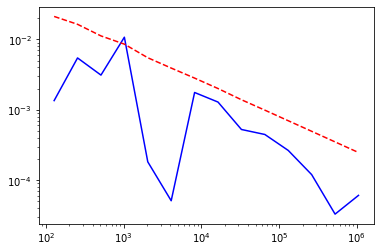

In [47]:
plt.loglog(M_vec, error, 'b-', M_vec, stat, 'r--')

The error is certainly in the range given by the statistical error estimate `stat`, which by construction behaves like $1/\sqrt{M}$. Nonetheless, let us fit an *empirical rate* by fitting an intercept $c_0$ and a slope $c_1$ in the log-coordinates.

In [48]:
c1, c0, _, _, _ = linregress(np.log(M_vec), np.log(error))
print(c1, c0)

-0.4452881396766422 -3.4169715749916687


We would expect a slope of $-1/2$, and the result is close enough. Let us now plot the error, and add the best fit as well as a line with slope $-1/2$ to it. Note that we should plot 
$$
\exp\left( c_0 + c_1 \log (M) \right) = e^{c_0} M^{c_1}.
$$

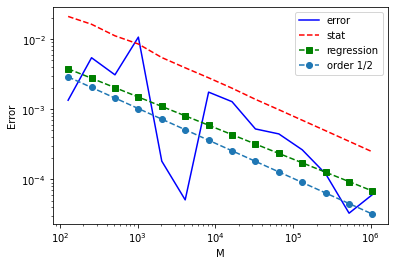

In [49]:
plt.loglog(M_vec, error, 'b-', label = "error")
plt.loglog(M_vec, stat, 'r--', label = "stat")
plt.loglog(M_vec, np.exp(c0) * M_vec**c1, 'sg--', label = "regression")
plt.loglog(M_vec, np.exp(c0) * M_vec**(-0.5), 'o--', label = "order 1/2")
plt.legend(loc = "upper right")
plt.xlabel("M")
plt.ylabel("Error")
plt.show()

### Quasi Monte Carlo based on Sobol numbers

Now we use the same function, but based on Sobol numbers.

In [50]:
def BS_put_QMC(S0, K, sigma, T, M):
    U = sobol(1, np.arange(M)).flatten()
    W_T = np.sqrt(T) * norm.ppf(U)
    S_T = S0 * np.exp(sigma * W_T - 0.5 * sigma**2 * T)
    payoff = np.maximum(K - S_T, 0)
    return np.mean(payoff)

def test_qmc(M_vec):
    ref = BS_put(S0, K, sigma, T)
    res = np.array([BS_put_QMC(S0, K, sigma, T, M) for M in M_vec])
    return np.abs(res - ref)

In [51]:
error_qmc = test_qmc(M_vec)

Now let us try regression to find a rate of convergence.

In [52]:
d1, d0, _, _, _ = linregress(np.log(M_vec), np.log(error_qmc))
print(d1, d0)

-1.0158285356104666 -0.33795596099735903


So, indeed, we obtain the rate $1$ that we expected or hoped to see!

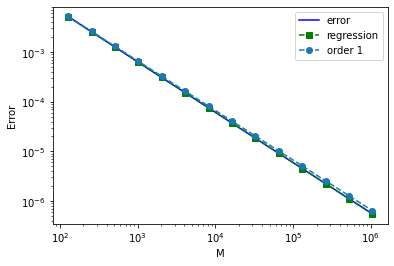

In [53]:
plt.loglog(M_vec, error_qmc, 'b-', label = "error")
plt.loglog(M_vec, np.exp(d0) * M_vec**d1, 'sg--', label = "regression")
plt.loglog(M_vec, error_qmc[0] * M_vec[0] / M_vec, 'o--', label = "order 1")
plt.legend(loc = "upper right")
plt.xlabel("M")
plt.ylabel("Error")
plt.show()

Let us now compare MC and QMC.

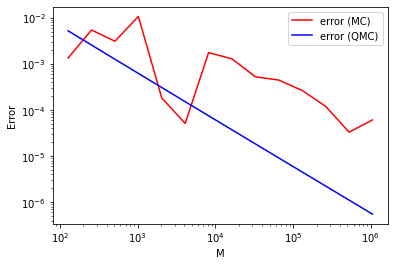

In [54]:
plt.loglog(M_vec, error, 'r-', label = "error (MC)")
plt.loglog(M_vec, error_qmc, 'b-', label = "error (QMC)")
plt.legend(loc = "upper right")
plt.xlabel("M")
plt.ylabel("Error")
plt.show()

Let us fix a certain error threshold and compare the timing. For a tolerance of $10^{-3}$ we roughly need $16384$ MC samples and $256$ QMC samples.

In [55]:
%timeit BS_put_MC(S0, K, sigma, T, 16384)

458 µs ± 5.33 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [56]:
%timeit BS_put_QMC(S0, K, sigma, T, 256)

2.08 ms ± 14.1 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


Surprisingly, the MC does better in this test! However, this is probably more due to the implementation than anything else!

## Euler scheme

Let us now (*stupidly*) compute the Black Scholes price by first solving the SDE
$$
dS_t = \sigma S_t dW_t.
$$
The following implementation returns an $M$-dimensional array of terminal values. We also return the terminal value of the Brownian motion in order to compute strong errors.

In [68]:
def euler_one_step(St, sigma, dw):
    """One step of the Euler scheme.
    
    Here dw is an M-dimensional array."""
    return St + sigma * St * dw

def euler(S0, sigma, T, N, M, method = "mc"):
    dt = T/N
    if method == "mc":
        rng = np.random.Generator(np.random.PCG64())
        dW = np.sqrt(dt) * rng.normal(size = (N,M))
    else:
        U = sobol(N, np.arange(1, M+1)) # Avoid 0!
        dW = np.sqrt(dt) * norm.ppf(U)
    WT = np.sum(dW, axis = 0)
    St = np.full(M, S0)
    for n in range(N):
        St = euler_one_step(St, sigma, dW[n,:])
    return (St, WT)

### Strong error

Note that $S_T = S_0 \exp( \sigma W_T - \frac{1}{2} \sigma^2 T)$, therefore we can compute the exact solution for any vector of increments `dW`.

Further, a strong error does not really make sense in the QMC framework.

As usual, we will report the statistical error incurred by computing an approximation of the strong error by MC!

In [18]:
def strong_error(N, M):
    ST_euler, WT = euler(S0, sigma, T, N, M, method = "mc")
    ST = S0 * np.exp(sigma * WT - 0.5 * sigma**2 * T)
    error_path = np.abs(ST - ST_euler)
    return np.mean(error_path), 1.96 * np.std(error_path) / np.sqrt(M)

We expect the strong error to have rate $1/2$, just like the Monte Carlo error. Hence, it makes sense to use $N$ proportional to $M$.

In [19]:
N_vec = 2**np.arange(1, 11)
M_vec = N_vec

def test_strong_euler(N_vec, M_vec):
    error = []
    stat = []
    for n in range(len(N_vec)):
        err, st = strong_error(N_vec[n], M_vec[n])
        error.append(err)
        stat.append(st)
    return np.array(error), np.array(stat)

In [20]:
error, stat = test_strong_euler(N_vec, M_vec)

In [21]:
d1, d0, _, _, _ = linregress(np.log(N_vec), np.log(error))
print(d1, d0)

-0.43919664717510387 -3.332311806180185


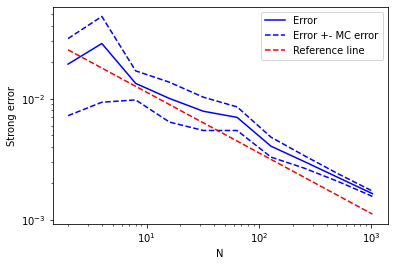

In [22]:
plt.loglog(N_vec, error, 'b-', label = "Error")
plt.loglog(N_vec, error + stat, 'b--', label = "Error +- MC error")
plt.loglog(N_vec, error - stat, 'b--')
plt.loglog(N_vec, np.exp(d0) * N_vec**(-0.5), 'r--', label = "Reference line")
plt.xlabel("N")
plt.ylabel("Strong error")
plt.legend(loc = "upper right")
plt.show()

Note that the Monte Carlo error decreases muich faster than the strong error! The reason is that here the Monte Carlo error effectively decreses like $\frac{1}{\sqrt{NM}} = \frac{1}{M}$, since the standard deviation of the random variable is of the order of the strong error.

### Weak error

We start with the Euler Monte Carlo method.

In [23]:
def BS_put_euler_MC(S0, K, sigma, T, N, M):
    S_T, _ = euler(S0, sigma, T, N, M, method = "mc")
    payoff = np.maximum(K - S_T, 0)
    return (np.mean(payoff), 1.96 * np.std(payoff) / np.sqrt(M))

In [24]:
def test_euler_MC(N_vec, M_vec):
    ref = BS_put(S0, K, sigma, T)
    error = []
    stat = []
    for n in range(len(N_vec)):
        res, st = BS_put_euler_MC(S0, K, sigma, T, N_vec[n], M_vec[n])
        error.append(np.abs(res - ref))
        stat.append(st)
    return np.array(error), np.array(stat)

In [61]:
def BS_put_euler_QMC(S0, K, sigma, T, N, M):
    S_T, _ = euler(S0, sigma, T, N, M, method = "qmc")
    payoff = np.maximum(K - S_T, 0)
    return np.mean(payoff)

def test_euler_QMC(N_vec, M_vec):
    ref = BS_put(S0, K, sigma, T)
    error = []
    for n in range(len(N_vec)):
        res = BS_put_euler_QMC(S0, K, sigma, T, N_vec[n], M_vec[n])
        error.append(np.abs(res - ref))
    return np.array(error)

In this test, we are traing to check the **weak rate** of convergence of the Euler method. Hence, we need to make sure that the Monte Carlo error is much smaller than the discretization error, so as not to pollute the convergence.

**Note:** In real life, we should never make one error component much smaller than the other!

**Note:** On my laptop, the code below uses about 60% of RAM! So we are already at the memory bounds...

In [25]:
N_vec = 2**np.arange(1, 11)
M_vec = N_vec * N_vec
error, stat = test_euler_MC(N_vec, M_vec)

In [26]:
error, stat

(array([3.94513731e-02, 1.37706095e-03, 1.33615005e-02, 8.22975255e-03,
        4.69105449e-04, 2.32161568e-04, 1.01029177e-04, 2.18329989e-04,
        1.14244918e-04, 2.45087969e-05]),
 array([0.13358724, 0.05985087, 0.02763196, 0.01697851, 0.00792825,
        0.00395822, 0.00199081, 0.00098961, 0.00049623, 0.0002475 ]))

Unfortunately, we see that the Monte Carlo error is the dominant error term. As we cannot savely increase the number of samples anymore, we have to reduce the number of steps - or re-write the code. While re-writing the Monte Carlo code is quite easy, rewriting the QMC code would be more challenging, but also hopefully not needed due to the superior error.

In [27]:
def euler_MC_2(S0, sigma, T, N, M):
    dt = T/N
    rng = np.random.Generator(np.random.PCG64())
    St = np.full(M, S0)
    for n in range(N):
        dW = np.sqrt(dt) * rng.normal(size = M)
        St = euler_one_step(St, sigma, dW)
    return St

def BS_put_euler_MC_2(S0, K, sigma, T, N, M):
    S_T = euler_MC_2(S0, sigma, T, N, M)
    payoff = np.maximum(K - S_T, 0)
    return (np.mean(payoff), 1.96 * np.std(payoff) / np.sqrt(M))

def test_euler_MC_2(N_vec, M_vec):
    ref = BS_put(S0, K, sigma, T)
    error = []
    stat = []
    for n in range(len(N_vec)):
        res, st = BS_put_euler_MC_2(S0, K, sigma, T, N_vec[n], M_vec[n])
        error.append(np.abs(res - ref))
        stat.append(st)
    return np.array(error), np.array(stat)

In [28]:
N_vec = 2**np.arange(1, 8)
M_vec = 20000 * N_vec * N_vec
error, stat = test_euler_MC_2(N_vec, M_vec)
print(stat / error) # want considerably smaller than 1!

[0.3920388  0.27008086 0.21617643 0.21839832 0.21013846 0.23138647
 0.22790618]


Let us see which rate of weak convergence regressioin gives us:

In [29]:
d1, d0, _, _, _ = linregress(np.log(N_vec), np.log(error))
print(d1, d0)

-0.9206427078033035 -5.114409863697306


As expected, we obtain rate $1$.

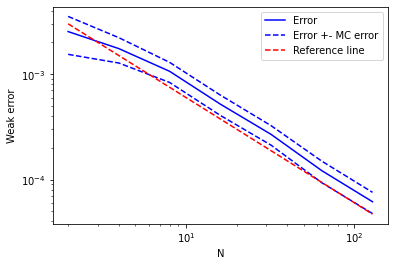

In [30]:
plt.loglog(N_vec, error, 'b-', label = "Error")
plt.loglog(N_vec, error + stat, 'b--', label = "Error +- MC error")
plt.loglog(N_vec, error - stat, 'b--')
plt.loglog(N_vec, np.exp(d0) / N_vec, 'r--', label = "Reference line")
plt.xlabel("N")
plt.ylabel("Weak error")
plt.legend(loc = "upper right")
plt.show()

How do we need to choose $N$ and $M$ to equidistribute the discretization and the statistical error?

In [74]:
N_vec = 2**np.arange(1, 7)
M_vec = 1000 * N_vec * N_vec
error, stat = test_euler_MC_2(N_vec, M_vec)
print(stat / error) # want = 1
print(N_vec)
print(M_vec)

[3.73844311 9.61266169 1.6736475  0.61010859 0.85013279 0.58017432]
[ 2  4  8 16 32 64]
[   4000   16000   64000  256000 1024000 4096000]


Hence, we roughly need $M = 1000 \times N$ in **this case**.

**Note:** The package `sobol_seq` only supports dimensions below $40$, hence could not be tested with this code.

In [71]:
N_vec = 2**np.arange(1, 7)
M_vec = 1000 * N_vec
error_QMC = test_euler_QMC(N_vec, M_vec)

In [77]:
print(error_QMC)
print(error_QMC/error)
print(1000 * N_vec * N_vec)
print(1000 * N_vec)

[2.57897537e-03 1.50907243e-03 1.23879204e-03 8.90673025e-04
 6.21744256e-05 2.88113542e-04]
[2.2048245  6.90464437 2.0179138  1.06987459 0.2095345  1.32979004]
[   4000   16000   64000  256000 1024000 4096000]
[ 2000  4000  8000 16000 32000 64000]


We see that, indeed, using $M = 1000 \times N$ produces rougly the same errors as for MC. Let us now compare the runtimes for error roughly of order $10^{-4}$, i.e., $N = 64$.

In [78]:
N = 64
M_MC = 1000 * N * N
%timeit test_euler_MC_2(np.array([N]), np.array([M_MC]))
M_QMC = 1000 * N
%timeit test_euler_QMC(np.array([N]), np.array([M_QMC]))

3.55 s ± 17.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
724 ms ± 4.13 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


So, in this case QMC actually wins...